# Data Preparation brain_tumor_dataset

Link to download: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427

This data was used in the following papers:
1. Cheng, Jun, et al. "Enhanced Performance of Brain Tumor Classification via Tumor Region Augmentation and Partition." PloS one 10.10 (2015).
2. Cheng, Jun, et al. "Retrieval of Brain Tumors by Adaptive Spatial Pooling and Fisher Vector Representation." PloS one 11.6 (2016). Matlab source codes are available on github https://github.com/chengjun583/brainTumorRetrieval

Infos about the dataset:
- this dataset contains 3 different classes (glioma, meningeoma and pituatary tumors), which will get converted into 0, 1 and 2
- class variability:
    - glioma: 1426 images
    - meningeoma: 708 images
    - pituatary: 930 images
- it's important to note that one tumor is sliced multiple times, meaning there aren't 1426 glioma patients in this dataset!
- the images show coronar, axial and sagittal images!

In [1]:
# To-Do:
# [ ] rotate images 90 degrees to the right
# [ ] decrease size of images
# [ ] percentile normalize the images
# [ ] save images as .tfrecord files
# [ ] split dataset into train, validation and testing sets

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
path_to_brain_tumor_dataset_pngs = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/brain_tumor_dataset/brainTumorDataPublic_png"

In [4]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

# CONSTANTS
IMG_SIZE = 512
SEED = 42
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
# save all paths to the images in lists
paths_to_glioma_images = []
paths_to_meningioma_images = []
paths_to_pituitary_images = []

paths_to_glioma_images = [os.path.join(path_to_brain_tumor_dataset_pngs, "glioma", image) for image in os.listdir(os.path.join(path_to_brain_tumor_dataset_pngs, "glioma"))]
paths_to_meningioma_images = [os.path.join(path_to_brain_tumor_dataset_pngs, "meningioma", image) for image in os.listdir(os.path.join(path_to_brain_tumor_dataset_pngs, "meningioma"))]
paths_to_pituitary_images = [os.path.join(path_to_brain_tumor_dataset_pngs, "pituitary", image) for image in os.listdir(os.path.join(path_to_brain_tumor_dataset_pngs, "pituitary"))]

# remove any .DR_Store files
paths_to_glioma_images = [image for image in paths_to_glioma_images if not image.endswith(".DS_Store")]
paths_to_meningioma_images = [image for image in paths_to_meningioma_images if not image.endswith(".DS_Store")]
paths_to_pituitary_images = [image for image in paths_to_pituitary_images if not image.endswith(".DS_Store")]

had some file size issues so I added the code below to check for them, they should be fixed though

In [6]:
# def check_shape_of_images(paths_to_images, print_file_name = False):
#     # go through all images and check their shapes
#     image_shape = None

#     for image in tqdm(paths_to_images):
#         if print_file_name:
#             print(image)
#         img = tf.io.read_file(image)
#         img = tf.image.decode_png(img, channels=3)
#         if image_shape is None:
#             image_shape = img.shape
#         elif image_shape != img.shape:
#             print("Image shapes are not the same!")
#             print(image)
#             print(image_shape)
#             print(img.shape)

# check_shape_of_images(paths_to_glioma_images)
# check_shape_of_images(paths_to_meningioma_images)
# check_shape_of_images(paths_to_pituitary_images, print_file_name=False)

In [7]:
print("Training Dataset")
train_ds = tf.keras.utils.image_dataset_from_directory(
    path_to_brain_tumor_dataset_pngs,
    validation_split = 0.2,
    subset = "training",
    seed = SEED,
    image_size = (IMG_SIZE, IMG_SIZE),
    #batch_size = BATCH_SIZE
)

print()

print("Validation Dataset")
val_ds = tf.keras.utils.image_dataset_from_directory(
    path_to_brain_tumor_dataset_pngs,
    validation_split = 0.2,
    subset = "validation",
    seed = SEED,
    image_size = (IMG_SIZE, IMG_SIZE),
    #batch_size = BATCH_SIZE
)

class_names = train_ds.class_names
print(f"\nClass Names\n{class_names}")

Training Dataset
Found 3049 files belonging to 3 classes.
Using 2440 files for training.

Validation Dataset
Found 3049 files belonging to 3 classes.
Using 609 files for validation.

Class Names
['glioma', 'meningioma', 'pituitary']


2025-01-16 20:02:38.661304: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


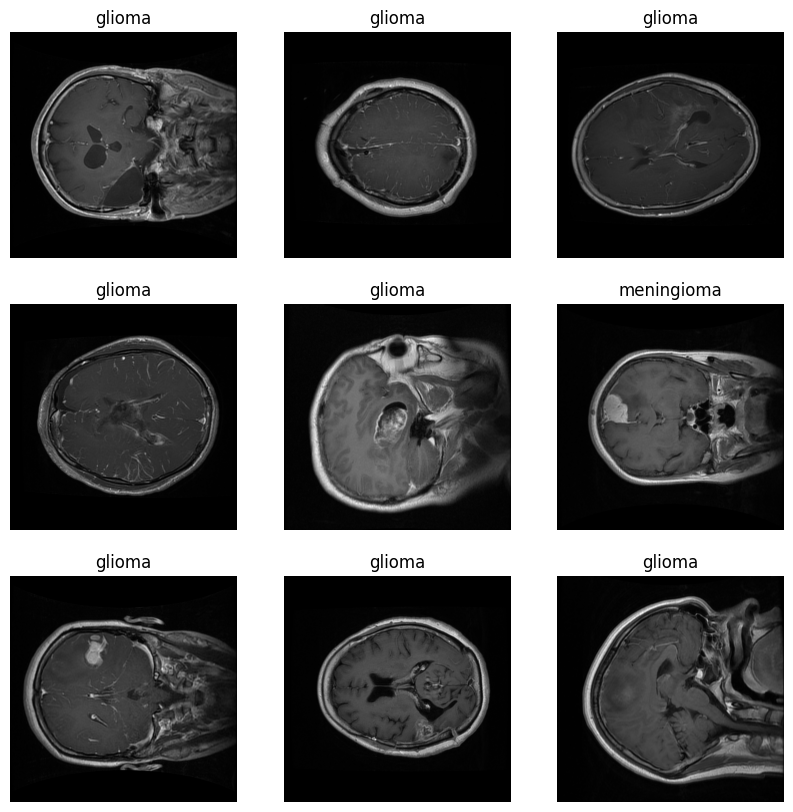

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
def data_preprocessing(image, label):
    # Rotate the image 90 degrees counter-clockwise
    image = tf.image.rot90(image, k=-1)

    # Zoom out by a factor of 2 while maintaining 512x512 resolution
    def zoom_out(image, zoom_factor):
        original_size = tf.shape(image)[:2]
        print("Original Size:", tf.shape(image))
        new_size = tf.cast(original_size * zoom_factor, tf.int32)
        resized_image = tf.image.resize(image, new_size)
        delta_height = original_size[0] - new_size[0]
        delta_width = original_size[1] - new_size[1]

        # Pad with black pixels to return to original size
        padded_image = tf.image.pad_to_bounding_box(
            resized_image,
            offset_height=delta_height // 2,
            offset_width=delta_width // 2,
            target_height=original_size[0],
            target_width=original_size[1]
        )
        return padded_image

    image = zoom_out(image, zoom_factor=0.5)

    # Percentile normalization (scaling between 1st and 99th percentiles)
    def percentile_normalize(img):
        flat_img = tf.reshape(img, [-1])
        sorted_img = tf.sort(flat_img)
        n = tf.shape(sorted_img)[0]
        p1_idx = tf.cast(tf.math.round(0.01 * tf.cast(n, tf.float32)), tf.int32)
        p99_idx = tf.cast(tf.math.round(0.99 * tf.cast(n, tf.float32)), tf.int32)
        p1 = sorted_img[p1_idx]
        p99 = sorted_img[p99_idx]
        img = tf.clip_by_value(img, p1, p99)
        img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
        return img

    image = percentile_normalize(image)

    return image, label

In [10]:
# turn datasets into datasets that are prefetched and batched

train_ds = (
    train_ds
    .shuffle(1000, seed = SEED)
    .map(data_preprocessing, num_parallel_calls = AUTOTUNE)
    #.batch(BATCH_SIZE, drop_remainder = True)
    .prefetch(buffer_size = AUTOTUNE)
)

val_ds = (
    val_ds
    .map(data_preprocessing, num_parallel_calls = AUTOTUNE)
    #.batch(BATCH_SIZE, drop_remainder = True)
    .prefetch(buffer_size = AUTOTUNE)
)

Original Size: Tensor("Shape_1:0", shape=(4,), dtype=int32)
Original Size: Tensor("Shape_1:0", shape=(4,), dtype=int32)


Shape: (32, 512, 3)
Max value: 1.0
Mean value: 0.09836932
Min value: 0.0
Shape: (32, 512, 3)
Max value: 1.0
Mean value: 0.10807284
Min value: 0.0
Shape: (32, 512, 3)
Max value: 1.0
Mean value: 0.041407157
Min value: 0.0
Shape: (32, 512, 3)
Max value: 1.0
Mean value: 0.07228462
Min value: 0.0
Shape: (32, 512, 3)
Max value: 1.0
Mean value: 0.08576348
Min value: 0.0
Shape: (32, 512, 3)
Max value: 1.0
Mean value: 0.07869868
Min value: 0.0
Shape: (32, 512, 3)
Max value: 1.0
Mean value: 0.09586402
Min value: 0.0
Shape: (32, 512, 3)
Max value: 1.0
Mean value: 0.09813103
Min value: 0.0
Shape: (32, 512, 3)
Max value: 1.0
Mean value: 0.06647242
Min value: 0.0


2025-01-16 20:02:41.053697: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


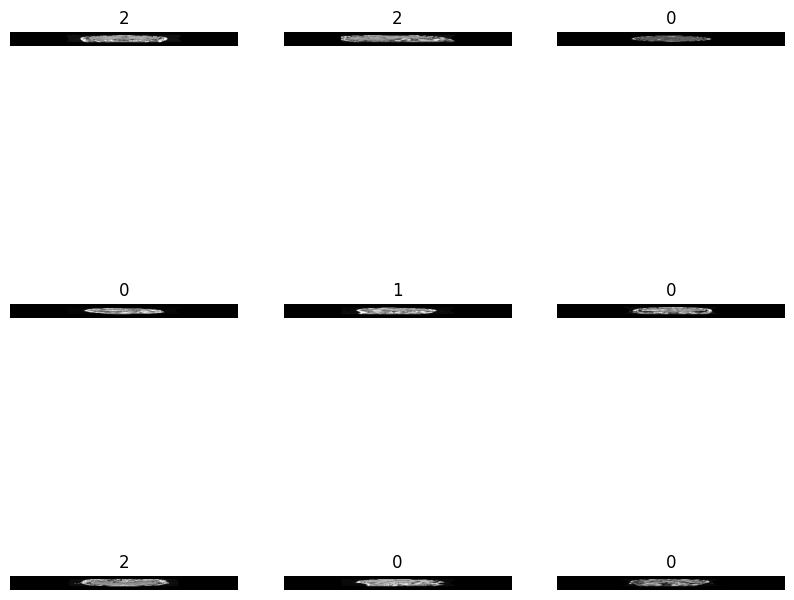

In [11]:
# Funktion zum Visualisieren von Bildern
def visualize_dataset(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(int(labels[i]))
            plt.axis("off")
            print("Shape:", images[i].numpy().shape)
            print("Max value:", np.array(images[i]).max())
            print("Mean value:", np.array(images[i]).mean())
            print("Min value:", np.array(images[i]).min())

# Visualisiere 9 Bilder aus dem train_ds
visualize_dataset(train_ds, 9)
plt.show()